### Домашнее задание
#### Практическое задание:
#### - взять любой набор данных для бинарной классификации (можно скачать один из модельных с 
https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)
- для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_absolute_error, r2_score, recall_score, precision_score, 
                            roc_auc_score, accuracy_score, f1_score)
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import xgboost as xgb

import shap
# load JS visualization code to notebook
shap.initjs()

In [2]:
# dataset из задания к уроку 6 файл "arrhythmia.data"
df = pd.read_csv("arrhythmia.data", header=None)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10


In [3]:
# повторяем все шаги до "обучить любой классификатор (какой вам нравится)" включительно.

# целевая пременная класс 2 с ишемическими изменениями, стальное приравняем к норме.
data = df.copy()
data[279].replace([1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 0, inplace=True)
data[279].replace(2, 1, inplace=True)
data[279]

0      0
1      0
2      0
3      0
4      0
      ..
447    0
448    0
449    1
450    0
451    0
Name: 279, Length: 452, dtype: int64

In [4]:
data.iloc[:, -1].value_counts()

0    408
1     44
Name: 279, dtype: int64

In [5]:
def get_num_features(df):
    """
    функция возвращает список числовых признаков
    :param df
    :return: list
    """
    numerical_features = df.select_dtypes(include=[np.number])
    # print(f"count of numeric_features_train {numerical_features.shape[1]}")
    return numerical_features.columns


def get_cat_features(df):
    """
    функция возвращает список признаков с типом "объект"
    :param df:
    :return: list
    """
    categorical_features = df.select_dtypes(include=[np.object])
    return categorical_features.columns

In [6]:
get_num_features(data)

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            270, 271, 272, 273, 274, 275, 276, 277, 278, 279],
           dtype='int64', length=275)

In [7]:
get_cat_features(data)

Int64Index([10, 11, 12, 13, 14], dtype='int64')

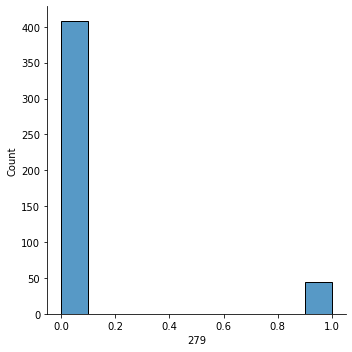

In [8]:
# выведем графически распределение целевой переменной
sns.displot(data, x=data[279]);

Налицо дисбаланс классов

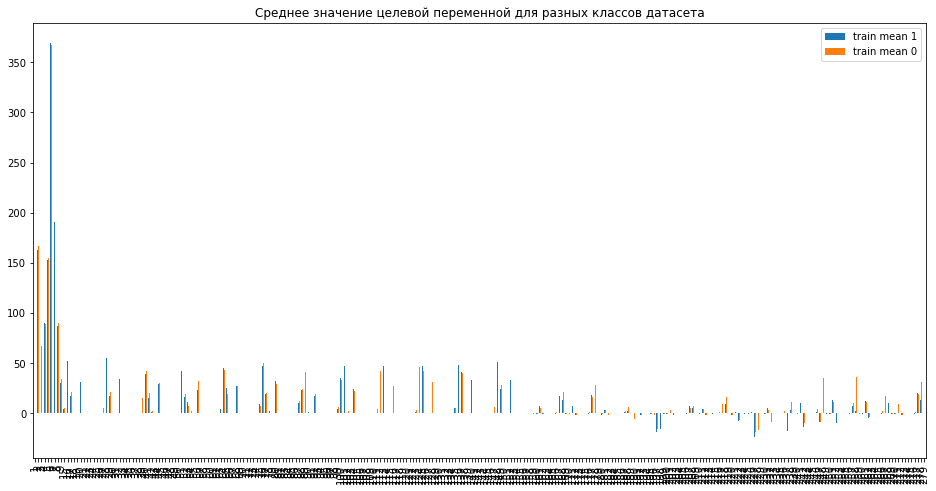

In [9]:
df = pd.DataFrame({
    # среднее по всем фичам трейна за исключением таргета
    'train mean 1': data.loc[data[279]==1, :].describe().iloc[1,1:],
    # среднее по всем фичам теста (здесь таргета нет)
    'train mean 0': data.loc[data[279]==0, :].describe().iloc[1,1:]
})

df.plot.bar(figsize=(16,8))
plt.title('Среднее значение целевой переменной для разных классов датасета');

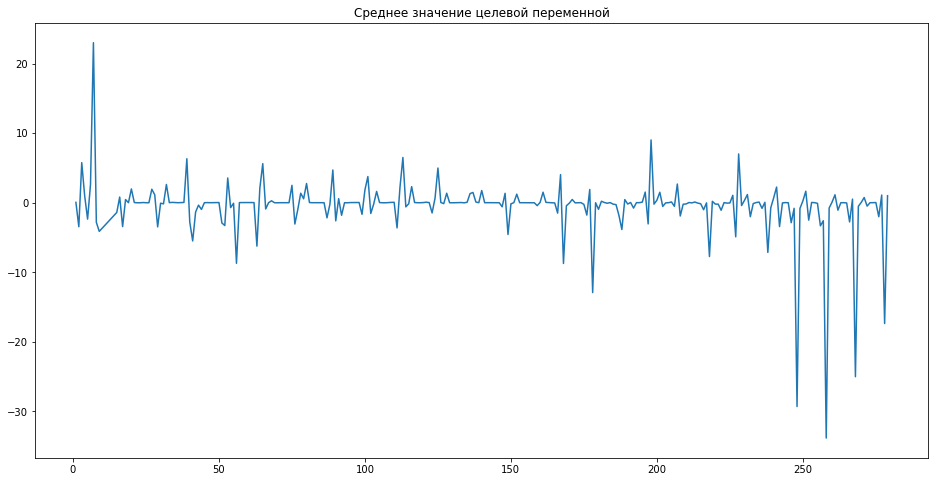

In [10]:
df =  data.loc[data[279]==1, :].describe().iloc[1,1:] - data.loc[data[279]==0, :].describe().iloc[1,1:]

df.plot(figsize=(16,8))
plt.title('Среднее значение целевой переменной');

In [11]:
data[10].unique()

array(['13', '37', '34', '11', '66', '49', '7', '69', '71', '42', '51',
       '20', '45', '75', '-24', '28', '39', '78', '56', '10', '17', '112',
       '52', '48', '153', '172', '16', '32', '46', '23', '35', '3', '-8',
       '-5', '4', '60', '8', '-18', '76', '64', '9', '79', '33', '14',
       '30', '53', '25', '62', '?', '43', '31', '19', '50', '68', '-164',
       '-56', '15', '-2', '87', '-136', '175', '-124', '142', '-13', '-9',
       '58', '47', '-165', '73', '21', '38', '70', '-92', '143', '22',
       '72', '57', '41', '65', '36', '63', '55', '44', '77', '24', '81',
       '12', '29', '18', '40', '54', '-1', '104', '-167', '-15', '67',
       '108', '-75', '160', '114', '-22', '120', '-115', '147', '-82',
       '-63', '-172', '102', '179', '86', '-52', '-49', '174', '-27',
       '95', '-123', '61', '137', '164', '5', '-177', '-103', '-106',
       '-42', '117', '127', '-160', '122', '59', '-16', '26', '100', '0',
       '-21', '-121', '-174', '-51', '105', '-116', '-4', '

In [12]:
for col in [10, 11, 12, 13, 14]:
    # извлекаем индексы по условию (тех элементов, которые имеют значение "?")
    indices = np.where(data[col] != '?')
    # получаем спиcок элементов по индексам [0], приводим к строке, к целому и находим медиану
    col_med = np.median(np.take(data[col], indices[0]).astype(str).astype(int))
    # заменяем некорректное значение медианой
    data[col] = data[col].replace('?', col_med)

In [13]:
data[10].unique()

array(['13', '37', '34', '11', '66', '49', '7', '69', '71', '42', '51',
       '20', '45', '75', '-24', '28', '39', '78', '56', '10', '17', '112',
       '52', '48', '153', '172', '16', '32', '46', '23', '35', '3', '-8',
       '-5', '4', '60', '8', '-18', '76', '64', '9', '79', '33', '14',
       '30', '53', '25', '62', 41.0, '43', '31', '19', '50', '68', '-164',
       '-56', '15', '-2', '87', '-136', '175', '-124', '142', '-13', '-9',
       '58', '47', '-165', '73', '21', '38', '70', '-92', '143', '22',
       '72', '57', '41', '65', '36', '63', '55', '44', '77', '24', '81',
       '12', '29', '18', '40', '54', '-1', '104', '-167', '-15', '67',
       '108', '-75', '160', '114', '-22', '120', '-115', '147', '-82',
       '-63', '-172', '102', '179', '86', '-52', '-49', '174', '-27',
       '95', '-123', '61', '137', '164', '5', '-177', '-103', '-106',
       '-42', '117', '127', '-160', '122', '59', '-16', '26', '100', '0',
       '-21', '-121', '-174', '-51', '105', '-116', '-4', 

In [14]:
# Коневертируем признаки в целые числа

for col in [10, 11, 12, 13, 14]:
    data[col] = data[col].astype(int)

In [15]:
data[10].unique()

array([  13,   37,   34,   11,   66,   49,    7,   69,   71,   42,   51,
         20,   45,   75,  -24,   28,   39,   78,   56,   10,   17,  112,
         52,   48,  153,  172,   16,   32,   46,   23,   35,    3,   -8,
         -5,    4,   60,    8,  -18,   76,   64,    9,   79,   33,   14,
         30,   53,   25,   62,   41,   43,   31,   19,   50,   68, -164,
        -56,   15,   -2,   87, -136,  175, -124,  142,  -13,   -9,   58,
         47, -165,   73,   21,   38,   70,  -92,  143,   22,   72,   57,
         65,   36,   63,   55,   44,   77,   24,   81,   12,   29,   18,
         40,   54,   -1,  104, -167,  -15,   67,  108,  -75,  160,  114,
        -22,  120, -115,  147,  -82,  -63, -172,  102,  179,   86,  -52,
        -49,  174,  -27,   95, -123,   61,  137,  164,    5, -177, -103,
       -106,  -42,  117,  127, -160,  122,   59,  -16,   26,  100,    0,
        -21, -121, -174,  -51,  105, -116,   -4, -119,   91,   84,  133,
       -163,  107, -132,  113,  145,   99,  125, -1

In [16]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 8}

forest = RandomForestRegressor(**parameters)
forest.fit(data.drop([279], axis=1), data[279])

Wall time: 102 ms


RandomForestRegressor(max_depth=6, n_estimators=25, n_jobs=8, random_state=27)

##### Находим 10 самых важных признаков

Text(0.5, 1.0, 'Топ 10 важных признаков')

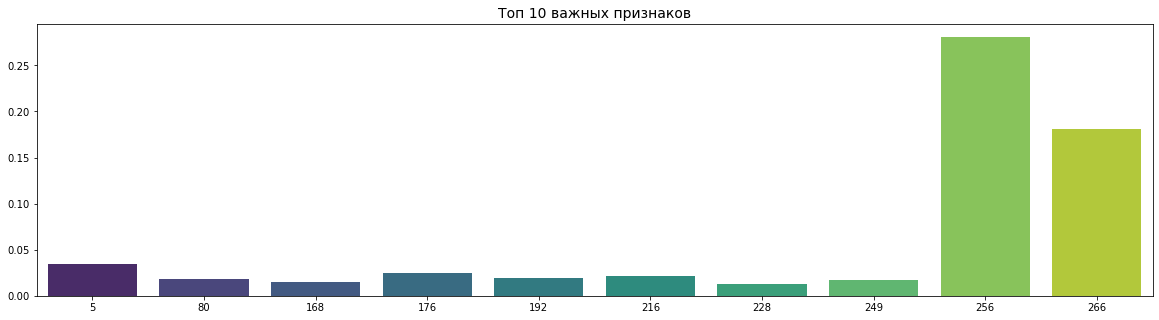

In [19]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = data.drop([279], axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("Топ 10 важных признаков", size=14)

##### Признак Body Mass Index = weight / (height (in meter) ** 2)

In [21]:
data['bmi'] = round(data[3] / ((data[2] / 100) ** 2), 1)
data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,bmi
0,75,0,190,80,91,193,371,174,121,-16,...,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,0,22.2
1,56,1,165,64,81,174,401,149,39,25,...,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,0,23.5
2,54,0,172,95,138,163,386,185,102,96,...,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,0,32.1
3,55,0,175,94,100,202,380,179,143,28,...,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,0,30.7
4,75,0,190,80,88,181,360,177,103,-16,...,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,0,22.2


<Figure size 1152x360 with 0 Axes>

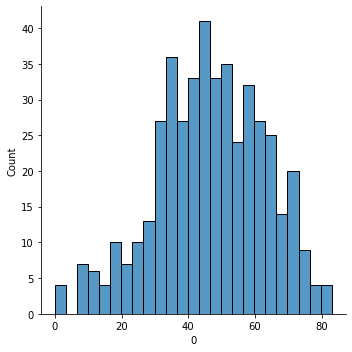

In [24]:
plt.figure(figsize=(16, 5))
sns.displot(data, x=data[0], bins=25 );

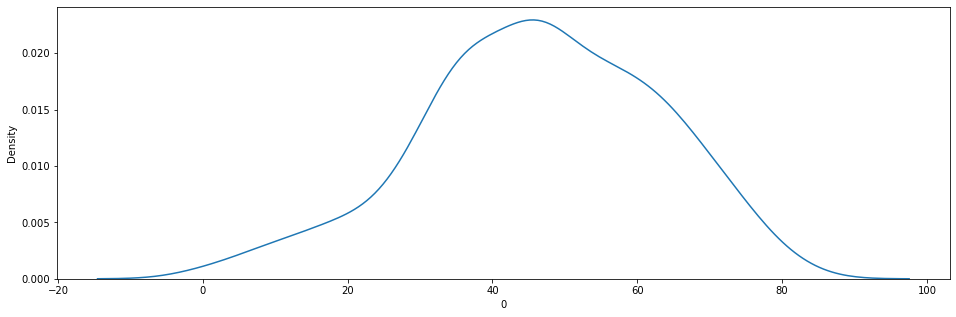

In [25]:
plt.figure(figsize=(16, 5))
sns.kdeplot(data=data[0]);

##### Признак Возраст в квадрате

In [26]:
data['Age Sqrt'] = np.sqrt(data[0])
data

,0,1,2,3,4,5,6,7,8,9,...,272,273,274,275,276,277,278,279,bmi,Age Sqrt
0,75,0,190,80,91,193,371,174,121,-16,...,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,0,22.2,8.660254
1,56,1,165,64,81,174,401,149,39,25,...,0.0,0.0,0.0,0.2,2.1,20.4,38.8,0,23.5,7.483315
2,54,0,172,95,138,163,386,185,102,96,...,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,0,32.1,7.348469
3,55,0,175,94,100,202,380,179,143,28,...,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,0,30.7,7.416198
4,75,0,190,80,88,181,360,177,103,-16,...,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,0,22.2,8.660254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,53,1,160,70,80,199,382,154,117,-37,...,-5.0,0.0,0.0,0.7,0.6,-4.4,-0.5,0,27.3,7.280110
448,37,0,190,85,100,137,361,201,73,86,...,-1.6,0.0,0.0,0.4,2.4,38.0,62.4,0,23.5,6.082763
449,36,0,166,68,108,176,365,194,116,-85,...,-28.6,0.0,0.0,1.5,1.0,-44.2,-33.2,1,24.7,6.000000
450,32,1,155,55,93,106,386,218,63,54,...,-0.7,0.0,0.0,0.5,2.4,25.0,46.6,0,22.9,5.656854


##### Признак Пульс разделённый на возраст

In [27]:
data['Heart_rate_age'] = data[14] / data[0]
data

,0,1,2,3,4,5,6,7,8,9,...,273,274,275,276,277,278,279,bmi,Age Sqrt,Heart_rate_age
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,0.0,0.9,2.9,23.3,49.4,0,22.2,8.660254,0.840000
1,56,1,165,64,81,174,401,149,39,25,...,0.0,0.0,0.2,2.1,20.4,38.8,0,23.5,7.483315,0.946429
2,54,0,172,95,138,163,386,185,102,96,...,0.0,0.0,0.3,3.4,12.3,49.0,0,32.1,7.348469,1.388889
3,55,0,175,94,100,202,380,179,143,28,...,0.0,0.0,0.4,2.6,34.6,61.6,0,30.7,7.416198,1.290909
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,0.0,-0.1,3.9,25.4,62.8,0,22.2,8.660254,0.960000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,53,1,160,70,80,199,382,154,117,-37,...,0.0,0.0,0.7,0.6,-4.4,-0.5,0,27.3,7.280110,1.188679
448,37,0,190,85,100,137,361,201,73,86,...,0.0,0.0,0.4,2.4,38.0,62.4,0,23.5,6.082763,1.972973
449,36,0,166,68,108,176,365,194,116,-85,...,0.0,0.0,1.5,1.0,-44.2,-33.2,1,24.7,6.000000,2.333333
450,32,1,155,55,93,106,386,218,63,54,...,0.0,0.0,0.5,2.4,25.0,46.6,0,22.9,5.656854,2.500000


##### Создаём X и Y. Разбиваем выборку на тренировочную и тестовую части и обучаем модель

In [28]:
x_data = data.drop([279], axis=1)
y_data = data[279]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

In [29]:
model = xgb.XGBClassifier()

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

[10:31:06] WARNING: D:\Build\xgboost\xgboost-1.3.3.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [30]:
def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 
    return f1, roc, rec, prc

In [31]:
f1, roc, rec, prc = evaluate_results(y_test, y_predict)

score = []
score.append([f1, prc, rec, roc])

Classification results:
f1: 54.55%
roc: 71.15%
recall: 46.15%
precision: 66.67%


##### - разобраться с SHAP и построить важности признаков для:
##### - всего тестового набора данных (summary_plot - дать интерпретацию)
##### - для топ 10%
##### - для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [32]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

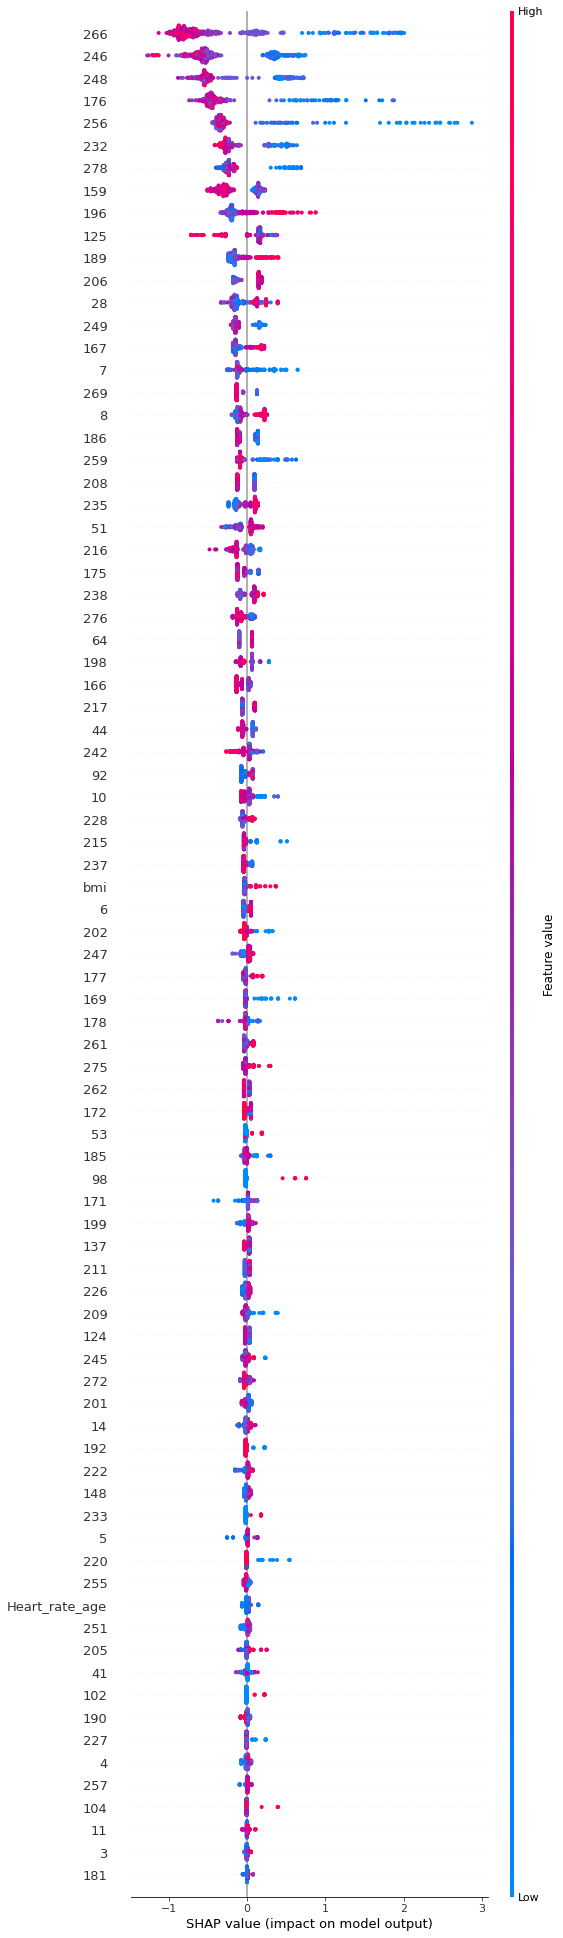

In [33]:
# summarize the effects of all the features
shap.summary_plot(shap_values, x_train, max_display=83)

Интерпретация summary_plot

- индекс массы тела bmi показывает что его превышение увеличивает риск нарушений работы сердца. А его уменьшение, не снижает, а просто оставляет в районе нуля.
- 14-й признак (пульс) - увеличение пульса увеличивает риск нарушений работы сердца
- heart_rate_age - отношение пульса к возрасту показывает, что повышенное или пониженное отношение понижает риски.
- признак 3 (вес) ясно показывает что повышенный вес повышает, а пониженый - снижает риск.

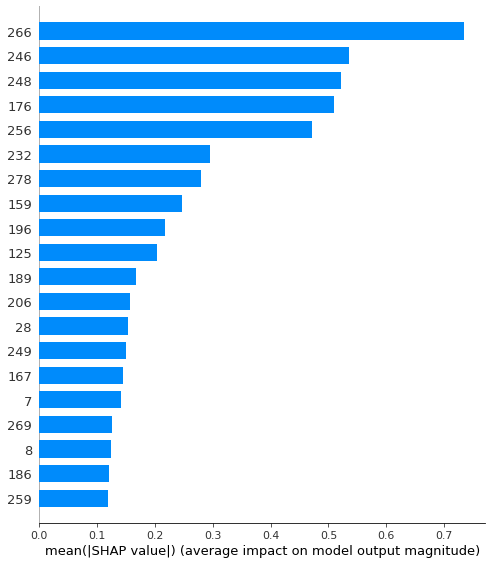

In [36]:
#  средние значения SHAP для каждого признака
shap.summary_plot(shap_values, x_train, plot_type="bar")

Наибольший вклад вносят признаки 266, 246, 248, 176, 256. 

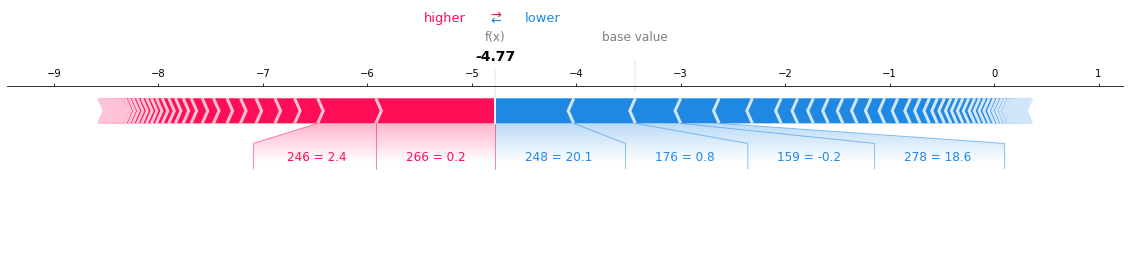

In [37]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[196,:], x_train.iloc[196,:], matplotlib=True)

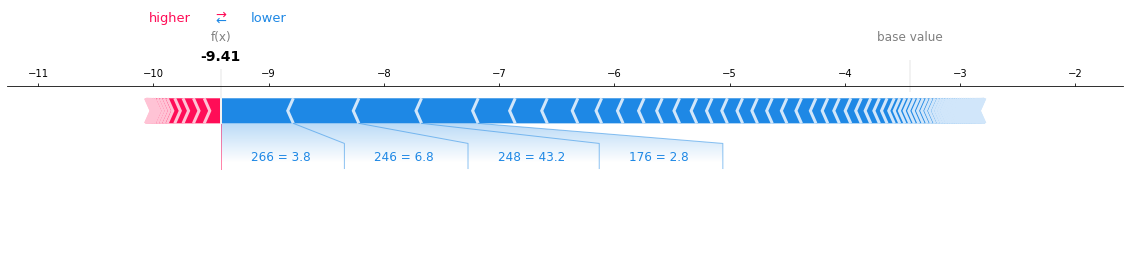

In [38]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[176,:], x_train.iloc[176,:], matplotlib=True)

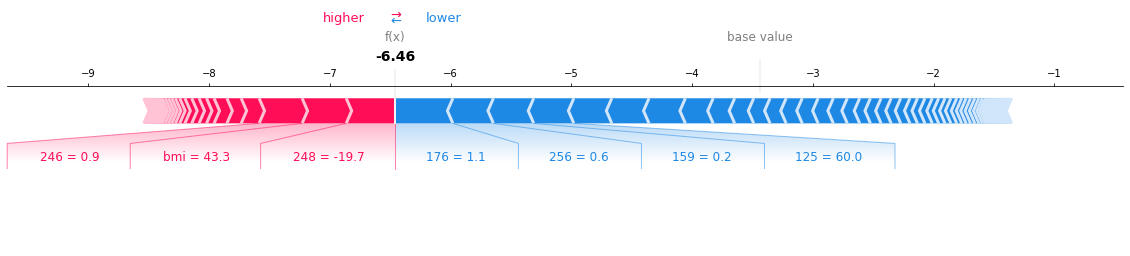

In [39]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[25,:], x_train.iloc[25,:], matplotlib=True)

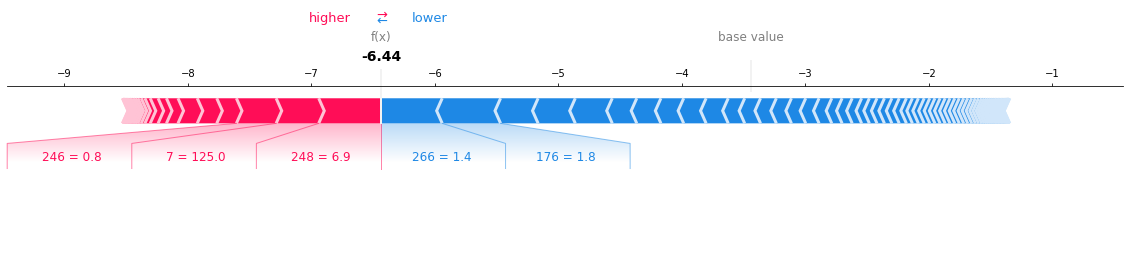

In [40]:
shap.force_plot(explainer.expected_value, shap_values[20,:], x_train.iloc[20,:], matplotlib=True)

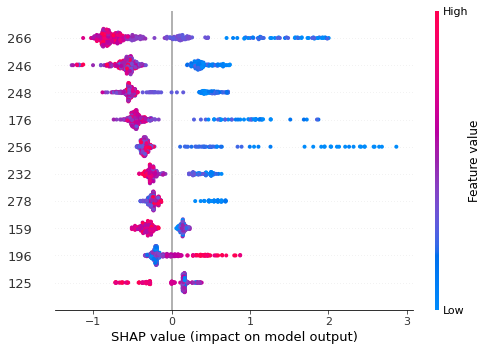

In [41]:
# summary_plot для топ 10%
shap.summary_plot(shap_values, x_train, max_display=10)

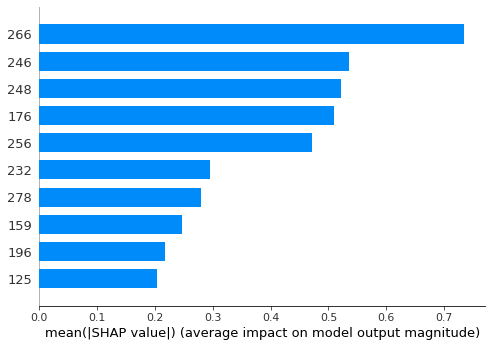

In [43]:
# summary_plot для топ 10% в виде баров
shap.summary_plot(shap_values, x_train, plot_type="bar", max_display=10)